# Removing Unfair Bias in Machine Learning

AI can embed human and societal bias and be then deployed at scale. Many algorithms are now being reexamined due to illegal bias. So how do you remove bias & discrimination in the machine learning pipeline? In this workshop you will learn the debiasing techniques that can be implemented by using the open source toolkit [AI Fairness 360](https://github.com/IBM/AIF360). 
 
**AI Fairness 360** (AIF360) is an extensible, open source toolkit for measuring, understanding, and removing AI bias. It contains the most widely used bias metrics, bias mitigation algorithms, and metric explainers from the top AI fairness researchers across industry & academia. 

In this notebook you will: 
* apply a practical use case of bias measurement & mitigation
* measure bias in data & models 
* apply the fairness algorithms to reduce bias

## 1. Import packages

### Install aif360

After running the below cell, restart the kernel before continuing with the rest of the notebook.

In [ ]:
#!pip install aif360

In [ ]:
# In case of an error with loading the aif360 Reweighing algorithm run the below line of code 
# should be needed only temporary - until next release of aif360 - fix is submitted
#!pip install numba==0.48

In [1]:
import sys
sys.path.insert(1, "../")  

# data exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# aif360 data, metrics and algorithms
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display
%matplotlib inline

## 2. Explore the data

### Load data

In [2]:
#aif360_location = !python -c "from distutils.sysconfig import get_python_lib; print(get_python_lib())"
#import os
#install_loc = os.path.join(aif360_location[0], "aif360/data/raw/german/")
#%cd $install_loc

In [3]:
#!wget ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.data
#!wget ftp://ftp.ics.uci.edu/pub/machine-learning-databases/statlog/german/german.doc
#%cd -

In [46]:
dataset_german = GermanDataset()

### AIF360 data format

All variables of this dataset are described in the [documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.GermanDataset.html) with more details in the description of the [`StandardDataset`](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.StandardDataset.html). In short, the dataset class contains a numpy array or pandas DataFrame with several variables. 

In [5]:
type(dataset_german)

aif360.datasets.german_dataset.GermanDataset

In [6]:
type(dataset_german.features)

numpy.ndarray

In [7]:
print(f'labels: {dataset_german.label_names}')
print(f'protected attributes: {dataset_german.protected_attribute_names}')
print(f'number of features: {len(dataset_german.feature_names)}')

labels: ['credit']
protected attributes: ['sex', 'age']
number of features: 58


### Explore with pandas

<div class="alert alert-info" style="font-size:100%">
<b>If you are new to Pandas read this <a href="http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html">10 minute introduction</a> for a quick overview.<br>
</div>

Convert the data to a `features` DataFrame and `labels` Series:

In [8]:
features = pd.DataFrame(dataset_german.features, columns=dataset_german.feature_names)
labels = pd.Series(dataset_german.labels.ravel(), name=dataset_german.label_names[0])

In [9]:
features.describe()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,0.810000,1.407000,1.155000,0.690000,0.274000,0.269000,...,0.713000,0.108000,0.022000,0.2000,0.630000,0.148000,0.596000,0.404000,0.963000,0.037000
std,12.058814,2822.736876,1.118715,1.103718,0.392497,0.577654,0.362086,0.462725,0.446232,0.443662,...,0.452588,0.310536,0.146757,0.4002,0.483046,0.355278,0.490943,0.490943,0.188856,0.188856
min,4.000000,250.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,72.000000,18424.000000,4.000000,4.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Explore the distribution of the features

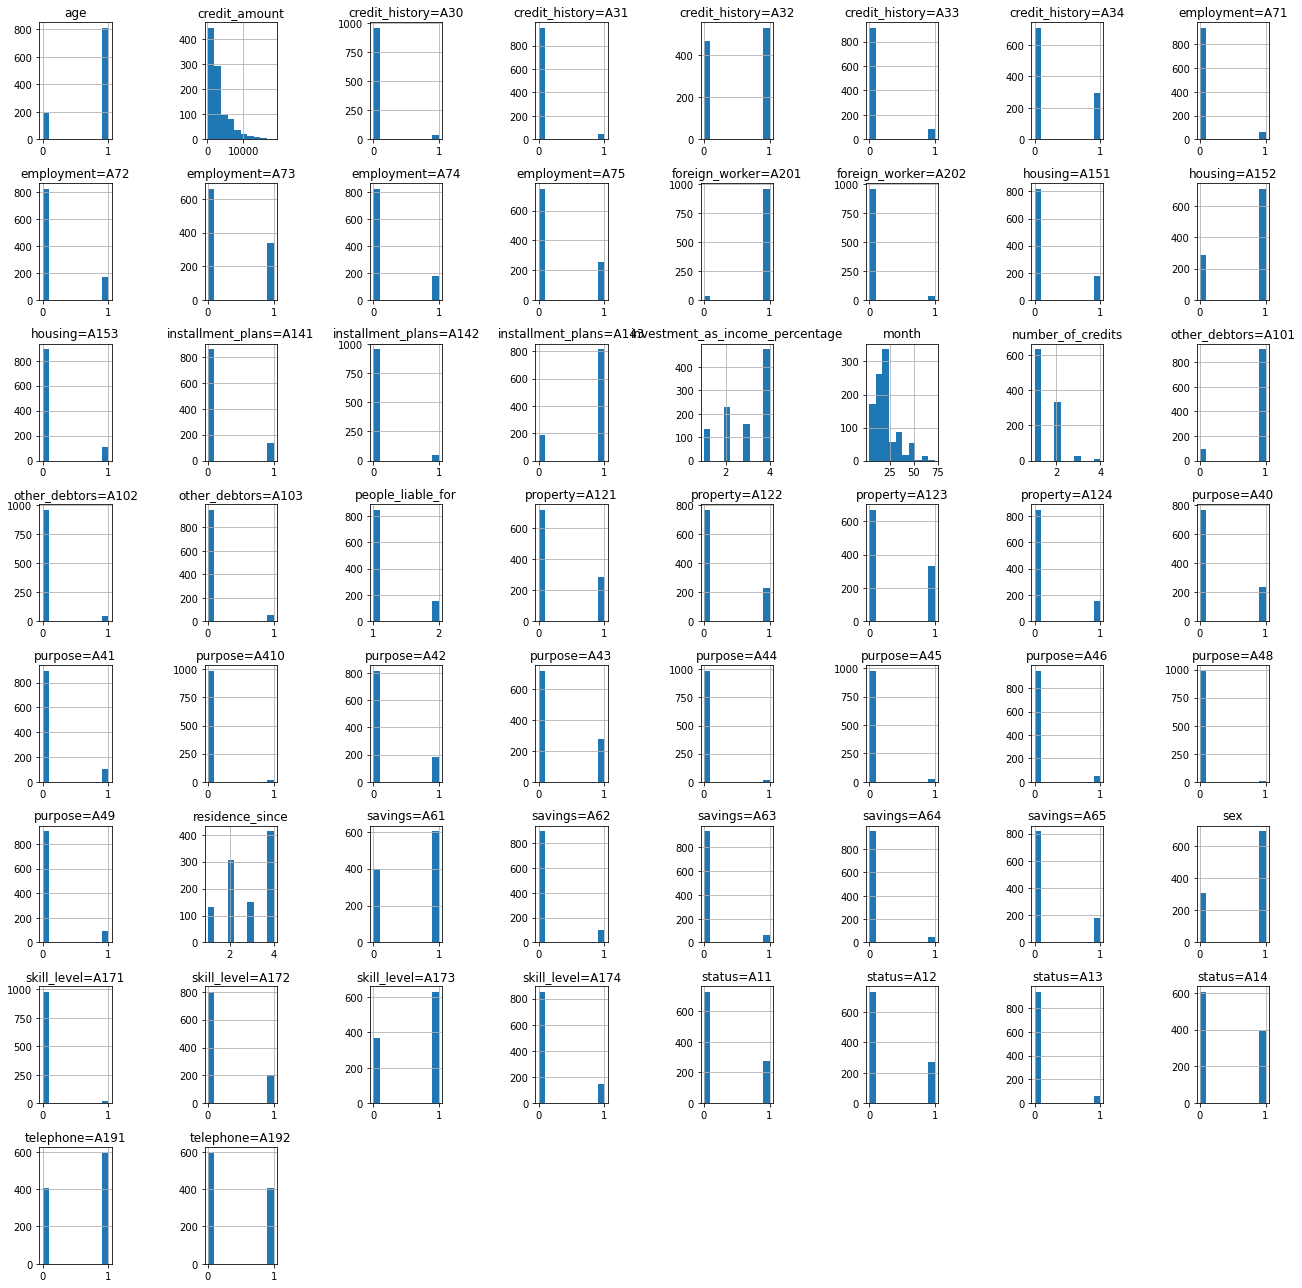

In [10]:
plt.rcParams["figure.figsize"] = (18,18)

features.hist();
plt.tight_layout()

Most features are binary, but a few are continuous:

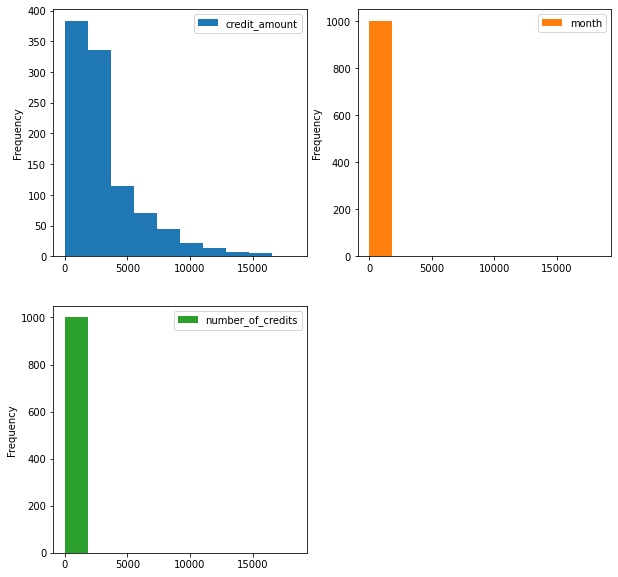

In [11]:
features[['credit_amount','month','number_of_credits']]. \
        plot(subplots=True, \
             kind='hist', \
             layout=(2, 2),
             sharex=False, \
             figsize=(10, 10));

And also add the labels:

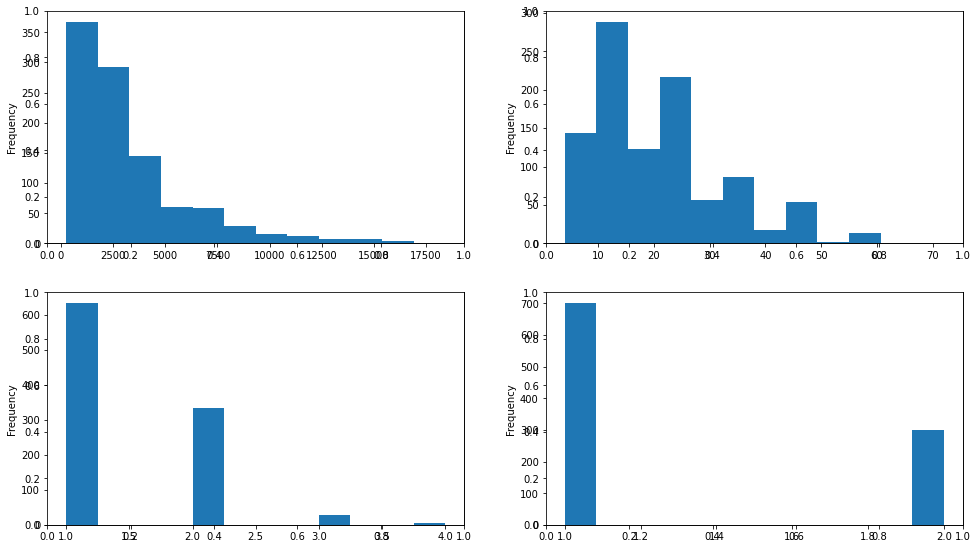

In [12]:
[fig, axs] = plt.subplots(2, 2, figsize=(14,8))
fig.add_subplot(2, 2, 1)
features['credit_amount'].plot(kind='hist',bins=12);
fig.add_subplot(2, 2, 2)
features['month'].plot(kind='hist',bins=12);
fig.add_subplot(2, 2, 3)
features['number_of_credits'].plot(kind='hist',bins=12);
fig.add_subplot(2, 2, 4)
labels.plot(kind='hist',bins=12);
plt.tight_layout()

### Explore bias in the data

Bias could occur based on age or sex in this dataset. 

* set the protected attribute to be `age`, `age >=25` is considered privileged
* this dataset also contains protected attribute for `sex` that are not consider in this evaluation
* split the original dataset into training and testing datasets
* set two variables for the privileged (1) and unprivileged (0) values for the age attribute. These are key inputs for detecting and mitigating bias

<div class="alert alert-success">
 <b>OPTIONAL EXERCISE</b> <br/> 
 To explore the gender bias in the data, edit the below code to use `sex` as the protected attribute and assign new privileged and unprivileged groups.
</div>

In [13]:
dataset_german = GermanDataset(protected_attribute_names=['age'],
                    privileged_classes=[lambda x: x >= 25],      
                    features_to_drop=['personal_status', 'sex']) 

dataset_german_train, dataset_german_test = dataset_german.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

### Metrics based on a single `BinaryLabelDataset`

<div class="alert alert-info" style="font-size:100%">
<b>Read <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html">the documentation</a> for a full overview of this class and a list of all bias metrics. <a href="http://aif360.mybluemix.net/data">This demo</a> contains definitions of the metrics as well.<br>
</div>

In [14]:
metric_german_train = BinaryLabelDatasetMetric(dataset_german_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_german_test = BinaryLabelDatasetMetric(dataset_german_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [15]:
help(metric_german_train)

Help on BinaryLabelDatasetMetric in module aif360.metrics.binary_label_dataset_metric object:

class BinaryLabelDatasetMetric(aif360.metrics.dataset_metric.DatasetMetric)
 |  BinaryLabelDatasetMetric(dataset, unprivileged_groups=None, privileged_groups=None)
 |  
 |  Class for computing metrics based on a single
 |  :obj:`~aif360.datasets.BinaryLabelDataset`.
 |  
 |  Method resolution order:
 |      BinaryLabelDatasetMetric
 |      aif360.metrics.dataset_metric.DatasetMetric
 |      aif360.metrics.metric.Metric
 |      abc.ApplyDecorator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset, unprivileged_groups=None, privileged_groups=None)
 |      Args:
 |          dataset (BinaryLabelDataset): A BinaryLabelDataset.
 |          privileged_groups (list(dict)): Privileged groups. Format is a list
 |              of `dicts` where the keys are `protected_attribute_names` and
 |              the values are values in `protected_attributes`. Each `dict`
 |  

### Exploring bias metrics
* `mean_difference`: alias of `statistical_parity_difference` 
    * Difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. 
    * A negative value indicates less favorable outcomes for the unprivileged groups
    * The ideal value of this metric is 0
    * Fairness for this metric is between -0.1 and 0.1

* `disparate_impact`: ratio of rate of favorable outcome for the unprivileged group to that of the privileged group

In [16]:
display(Markdown("#### Original training dataset"))
print("mean_difference = %f" % metric_german_train.mean_difference())
print("disparate_impact = %f" % metric_german_train.disparate_impact())
print("consistency = %f" % metric_german_train.consistency())
print("base_rate = %f" % metric_german_train.base_rate())
print("num_negatives = %f" % metric_german_train.num_negatives())
print("num_positives = %f" % metric_german_train.num_positives())
print("smoothed_empirical_differential_fairness = %f" % metric_german_train.smoothed_empirical_differential_fairness())

#### Original training dataset

mean_difference = -0.169905
disparate_impact = 0.766430
consistency = 0.677714
base_rate = 0.700000
num_negatives = 210.000000
num_positives = 490.000000
smoothed_empirical_differential_fairness = 0.484208


/Applications/anaconda3/envs/aif360/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


## 3. Select and transform features to build a model

### Classification problem

From the above
- mostly binary data, a few with a few classes and two continuous. 
- label is binary: 0 or 1 is what will be predicted, so this will be a **binary classification**

Some of the model options:
- logistical regression
- Decision trees
- Random forests
- Bayesian networks
- Support vector machines
- Neural networks
- Logistic regression

### Scale and normalise features

- one-hot encoding for multiple classes
- features need to be standardised, from same distribution
- no missing values
- ...

[StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html) - 
*Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. `StandardScaler` implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.*

aif360 format can be used with scikitlearn!

In [17]:
# scale data
scale_german = StandardScaler().fit(dataset_german_train.features)

X_train = scale_german.transform(dataset_german_train.features)
y_train = dataset_german_train.labels.ravel()
w_train = dataset_german_train.instance_weights.ravel()

X_test = scale_german.transform(dataset_german_test.features)
y_test = dataset_german_test.labels.ravel()
w_test = dataset_german_test.instance_weights.ravel()

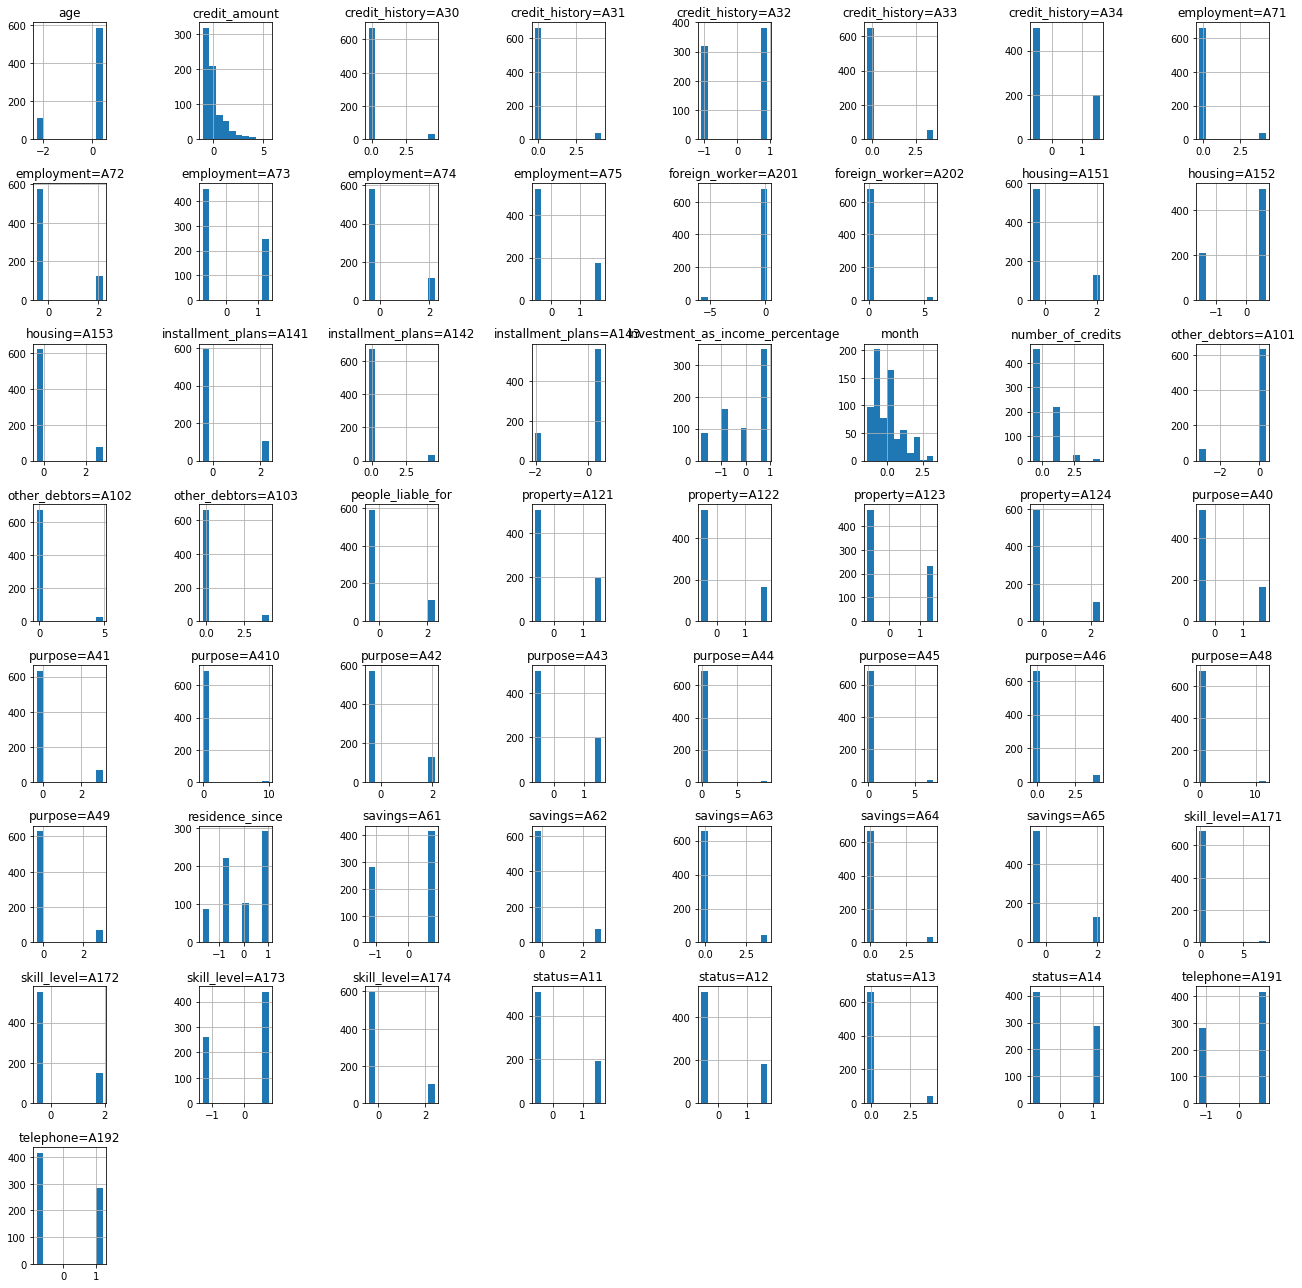

In [18]:
# what does the data look like now?
plt.rcParams["figure.figsize"] = (18,18)

scaled_features = pd.DataFrame(X_train, columns=dataset_german.feature_names)

scaled_features.hist();
plt.tight_layout()

In [19]:
scale_german.mean_

array([2.10342857e+01, 3.16113143e+03, 3.02000000e+00, 2.85285714e+00,
       8.38571429e-01, 1.39428571e+00, 1.15714286e+00, 2.72857143e-01,
       2.60000000e-01, 5.85714286e-02, 4.08571429e-01, 4.42857143e-02,
       5.42857143e-02, 5.44285714e-01, 7.42857143e-02, 2.82857143e-01,
       2.34285714e-01, 9.28571429e-02, 1.00000000e-02, 1.82857143e-01,
       2.84285714e-01, 1.14285714e-02, 2.00000000e-02, 5.57142857e-02,
       7.14285714e-03, 1.01428571e-01, 5.94285714e-01, 1.05714286e-01,
       6.42857143e-02, 4.85714286e-02, 1.87142857e-01, 5.42857143e-02,
       1.74285714e-01, 3.54285714e-01, 1.67142857e-01, 2.50000000e-01,
       9.04285714e-01, 4.00000000e-02, 5.57142857e-02, 2.81428571e-01,
       2.37142857e-01, 3.31428571e-01, 1.50000000e-01, 1.51428571e-01,
       4.42857143e-02, 8.04285714e-01, 1.82857143e-01, 7.05714286e-01,
       1.11428571e-01, 1.71428571e-02, 2.11428571e-01, 6.25714286e-01,
       1.45714286e-01, 5.95714286e-01, 4.04285714e-01, 9.71428571e-01,
      

In [20]:
scale_german.scale_

array([1.19031315e+01, 2.73440964e+03, 1.10564784e+00, 1.09794892e+00,
       3.67925791e-01, 5.84535399e-01, 3.63935406e-01, 4.45428022e-01,
       4.38634244e-01, 2.34820817e-01, 4.91569747e-01, 2.05729166e-01,
       2.26580616e-01, 4.98034914e-01, 2.62235289e-01, 4.50387588e-01,
       4.23551553e-01, 2.90232138e-01, 9.94987437e-02, 3.86549361e-01,
       4.51073549e-01, 1.06291859e-01, 1.40000000e-01, 2.29369144e-01,
       8.42130437e-02, 3.01895373e-01, 4.91029738e-01, 3.07471585e-01,
       2.45261210e-01, 2.14970335e-01, 3.90026163e-01, 2.26580616e-01,
       3.79354984e-01, 4.78296296e-01, 3.73103367e-01, 4.33012702e-01,
       2.94199016e-01, 1.95959179e-01, 2.29369144e-01, 4.49696042e-01,
       4.25330604e-01, 4.70726750e-01, 3.57071421e-01, 3.58466120e-01,
       2.05729166e-01, 3.96749548e-01, 3.86549361e-01, 4.55721003e-01,
       3.14662112e-01, 1.29803619e-01, 4.08321602e-01, 4.83937928e-01,
       3.52819547e-01, 4.90753274e-01, 4.90753274e-01, 1.66598626e-01,
      

## 4. Build models

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### Train on the original data

In [21]:
# Logistic regression classifier and predictions

# create an instance of the model
lmod = LogisticRegression()

# train the model
lmod.fit(X_train, y_train, 
         sample_weight=dataset_german_train.instance_weights)

# calculate predicted labels
y_train_pred = lmod.predict(X_train)

# assign positive class index
pos_ind = np.where(lmod.classes_ == dataset_german_train.favorable_label)[0][0]

# add predicted labels to predictions dataset
dataset_german_train_pred = dataset_german_train.copy()
dataset_german_train_pred.labels = y_train_pred

In [22]:
# model accuracy
score = lmod.score(X_test, y_test)
print(score)

0.7533333333333333


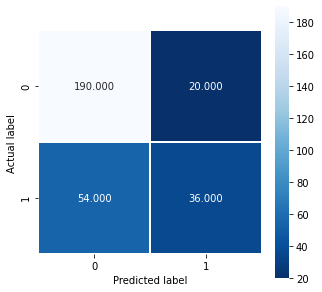

In [23]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, lmod.predict(X_test))

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

#### Train on transformed data




In [45]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

# compute the weights for reweighing the dataset
RW.fit(dataset_german_train)

# transform the dataset to a new dataset based on the estimated transformation
dataset_transf_train = RW.transform(dataset_german_train)
dataset_transf_test = RW.transform(dataset_german_test)

In [25]:
display(Markdown("#### Original training dataset"))
print("mean_difference = %f" % metric_german_train.mean_difference())
print("disparate_impact = %f" % metric_german_train.disparate_impact())
print("consistency = %f" % metric_german_train.consistency())
print("base_rate = %f" % metric_german_train.base_rate())
print("num_negatives = %f" % metric_german_train.num_negatives())
print("num_positives = %f" % metric_german_train.num_positives())
print("smoothed_empirical_differential_fairness = %f" % metric_german_train.smoothed_empirical_differential_fairness())

metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

display(Markdown("#### Reweighted training dataset"))
print("mean_difference = %f" % metric_transf_train.mean_difference())
print("disparate_impact = %f" % metric_transf_train.disparate_impact())
print("consistency = %f" % metric_transf_train.consistency())
print("base_rate = %f" % metric_transf_train.base_rate())
print("num_negatives = %f" % metric_transf_train.num_negatives())
print("num_positives = %f" % metric_transf_train.num_positives())
print("smoothed_empirical_differential_fairness = %f" % metric_german_train.smoothed_empirical_differential_fairness())

#### Original training dataset

mean_difference = -0.169905
disparate_impact = 0.766430
consistency = 0.677714
base_rate = 0.700000
num_negatives = 210.000000
num_positives = 490.000000
smoothed_empirical_differential_fairness = 0.484208


#### Transformed training dataset

mean_difference = 0.000000
disparate_impact = 1.000000
consistency = 0.677714
base_rate = 0.700000
num_negatives = 210.000000
num_positives = 490.000000
smoothed_empirical_differential_fairness = 0.484208


/Applications/anaconda3/envs/aif360/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Train on reweighted data

In [36]:
# scale data
scale_transf = StandardScaler().fit(dataset_transf_train.features)

X_train_transf = scale_transf.transform(dataset_transf_train.features)
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

X_test_transf = scale_transf.transform(dataset_transf_test.features)
y_test_transf = dataset_transf_test.labels.ravel()
w_test_transf = dataset_transf_test.instance_weights.ravel()

In [39]:
# create an instance of the model
lmod_transf = LogisticRegression()

# train the model
lmod_transf.fit(X_train_transf, y_train_transf, 
         sample_weight=dataset_transf_train.instance_weights)

# calculate predicted labels
y_train_pred_transf = lmod_transf.predict(X_train_transf)

# assign positive class index
pos_ind_transf = np.where(lmod_transf.classes_ == dataset_transf_train.favorable_label)[0][0]

# add predicted labels to predictions dataset
dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred_transf

In [40]:
# model accuracy
score = lmod_transf.score(X_test_transf, y_test_transf)
print(score)

0.7666666666666667


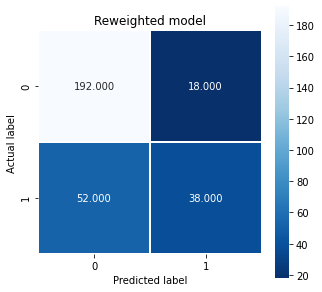

In [43]:
# confusion matrix
cm_transf = metrics.confusion_matrix(y_test_transf, lmod_transf.predict(X_test_transf))

plt.figure(figsize=(5,5))
sns.heatmap(cm_transf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Reweighted model');

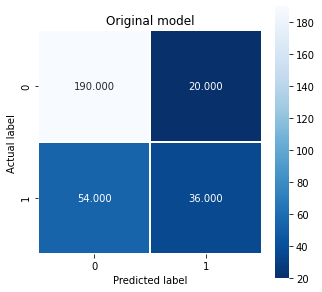

In [44]:
# confusion matrix
cm = metrics.confusion_matrix(y_test, lmod.predict(X_test))

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Original model');

**Optimized preprocessing** is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives
<div class="alert alert-info" style="font-size:100%">
<b>Read <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html">the documentation</a> for a full overview<br>
</div>

In [53]:

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_german_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_german_train.favorable_label)[0][0]

dataset_german_train_pred = dataset_german_train.copy()
dataset_german_train_pred.labels = y_train_pred

In [ ]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [52]:
pos_ind

0

## 5. Evaluate the models

### Quality metrics

https://www.neuraldesigner.com/blog/methods-binary-classification



### Fairness metrics

## 6. Improve models

The feature to use to explore bias can now be set to `age`. Here the privileged class is everyone over 25 years old. Also 2 features are dropped, which will not be taken into account for now. Two variables for the privileged (1) and unprivileged (0) values are set that are the key inputs for detecting and mitigating bias.

In [ ]:
dataset_age = GermanDataset(protected_attribute_names=['age'],           
    privileged_classes=[lambda x: x >= 25],      
    features_to_drop=['personal_status', 'sex'])

dataset_age_train, dataset_age_test = dataset_age.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}] 

## 7. Summarize results

### models

In [ ]:
# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [ ]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Step 3 Compute fairness metric on original training dataset
Now that we've identified the protected attribute 'age' and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset.  One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter.   A negative value indicates less favorable outcomes for the unprivileged groups.  This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class.  The code below performs this check and displays the output, showing that the difference is -0.169905.

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

### Step 4 Mitigate bias by transforming the original dataset
The previous step showed that the privileged group was getting 17% more positive outcomes in the training dataset.   Since this is not desirable, we are going to try to mitigate this bias in the training dataset.  As stated above, this is called _pre-processing_ mitigation because it happens before the creation of the model.  

AI Fairness 360 implements several pre-processing mitigation algorithms.  We will choose the Reweighing algorithm [1], which is implemented in the `Reweighing` class in the `aif360.algorithms.preprocessing` package.  This algorithm will transform the dataset to have more equity in positive outcomes on the protected attribute for the privileged and unprivileged groups.

We then call the fit and transform methods to perform the transformation, producing a newly transformed training dataset (dataset_transf_train).

`[1] F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.`

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

### Step 5 Compute fairness metric on transformed dataset
Now that we have a transformed dataset, we can check how effective it was in removing bias by using the same metric we used for the original training dataset in Step 3.  Once again, we use the function mean_difference in the BinaryLabelDatasetMetric class.   We see the mitigation step was very effective, the difference in mean outcomes is now 0.0.  So we went from a 17% advantage for the privileged group to equality in terms of mean outcome.

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

### Summary
The purpose of this tutorial is to give a new user to bias detection and mitigation a gentle introduction to some of the functionality of AI Fairness 360.  A more complete use case would take the next step and see how the transformed dataset impacts the accuracy and fairness of a trained model.  This is implemented in the demo notebook in the examples directory of toolkit, called demo_reweighing_preproc.ipynb.  I highly encourage readers to view that notebook as it is  generalization and extension of this simple tutorial.

There are many metrics one can use to detect the presence of bias. AI Fairness 360 provides many of them for your use. Since it is not clear which of these metrics to use, we also provide some guidance. Likewise, there are many different bias mitigation algorithms one can employ, many of which are in AI Fairness 360. Other tutorials will demonstrate the use of some of these metrics and mitigations algorithms.

As mentioned earlier, both fairness metrics and mitigation algorithms can be performed at various stages of the machine learning pipeline.  We recommend checking for bias as often as possible, using as many metrics are relevant for the application domain.  We also recommend incorporating bias detection in an automated continouus integration pipeline to ensure bias awareness as a software project evolves.